# Planaria single-cell

In [30]:
import numpy as np
import pandas as pd
import networkx as nx
import pyemb as eb
import matplotlib.pyplot as plt

This section uses [data](https://shiny.mdc-berlin.de/psca/) from the paper [Plass et al., 2018](https://www.science.org/doi/abs/10.1126/science.aaq1723). It contains expression levels of $p= 5821$ genes measured across $n=5000$ individual cells from adult planarians, a type of flatworm. Such data offer the possibility of discovering the cell lineage tree of an entire animal: the
aim is to find out if the data reflect the tree-structured process by which stem cells differentiate into a variety of distinct cell types. These data were prepared using the Python package [Scanpy](https://scanpy.readthedocs.io/en/stable/index.html), where the script on how to do this can be found [here](https://nbviewer.org/github/rajewsky-lab/planarian_lineages/blob/master/paga/preprocessing.ipynb).

## Load data

In [31]:
data = eb.load_planaria()

Y = data['Y']
labels = data['labels']
ordered_cats = data['cell_types']
colors = data['color_dict']

Data loaded successfully


In [32]:
(n,p) = Y.shape
print('Data matrix is', n, 'samples by', p, 'features')

Data matrix is 5000 samples by 100 features


## Dimension selection and visualisation

After selecting the dimension [Whiteley et al., 2022](https://arxiv.org/pdf/2208.11665), perform PCA with embedding function and visualise.

In [33]:
ws, dim = eb.wasserstein_dimension_select(Y, range(40), split=0.5)
print("Selected dimension: {}".format(dim))

100%|██████████| 40/40 [01:06<00:00,  1.67s/it]

Recommended dimension: 16, Wasserstein distance 0.18280
Selected dimension: 16


In [34]:
zeta = eb.embed(Y, d=14, version='full')

In [35]:
## TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity = 30).fit_transform(zeta)

We can plot the two representations of our data with the `snapshot_plot` function.

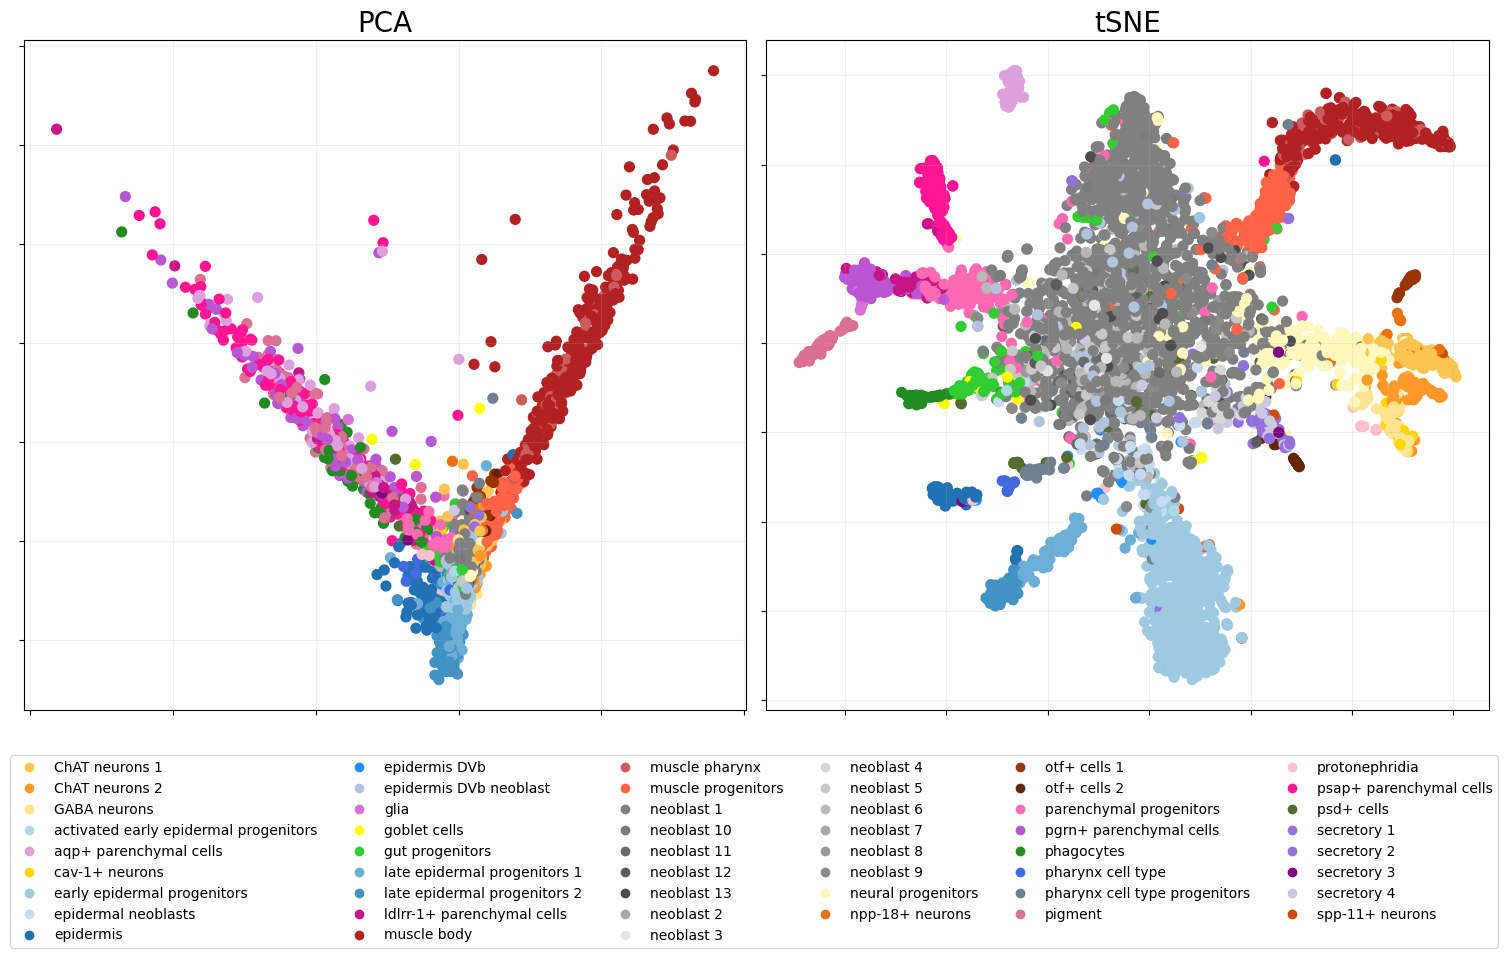

In [36]:
pca_fig = eb.snapshot_plot(
    embedding = [zeta[:,:2],tsne], 
    node_labels = labels.tolist(), 
    c = colors,
    title = ['PCA','tSNE'],
    add_legend=True, 
    max_legend_cols = 6,
   figsize = (15,7.5),
   move_legend= (.5,-.3),
    # Apply other matplotlib settings
    s=50,
)
plt.tight_layout()

## Construct tree

From here we want to perform hierarchical clustering on the data and simplify this tree. This can be done using the hierarchical clustering module. 

We use hierarchical clustering with dot products as descibed in [Gray et al., 2024](https://proceedings.neurips.cc/paper_files/paper/2023/file/6521937507d78f327cd402401be73bf2-Paper-Conference.pdf). This is the default HC in the class `ConstructTree` so we can just give it our point cloud. Otherwise, the HC can be done first and the model can be given to the `ConstructTree` class. 

The `epsilon` parameter controls the threshold for condensing tree and if set to zero the full tree will be given. 

This can then be plotted. Points are coloured by labels, if a plotted node is a collection of data points then `colour_threshold` controls when to colour this node by the majority type of data point (colour by majority if proportion of majority is greater than colour_threshold), else, if there is no majority node, it is plotted white. 

Layouts, node settings and others can also be changed. See the documentation for details of this.

In [37]:
tree = eb.ConstructTree(zeta, epsilon=0.2)
tree.fit()

Performing clustering...
Calculating branch lengths...
Constructing tree...


100%|██████████| 250/250 [00:03<00:00, 69.38it/s]


BarnesHut Approximation  took  2.26  seconds
Repulsion forces  took  1.08  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds


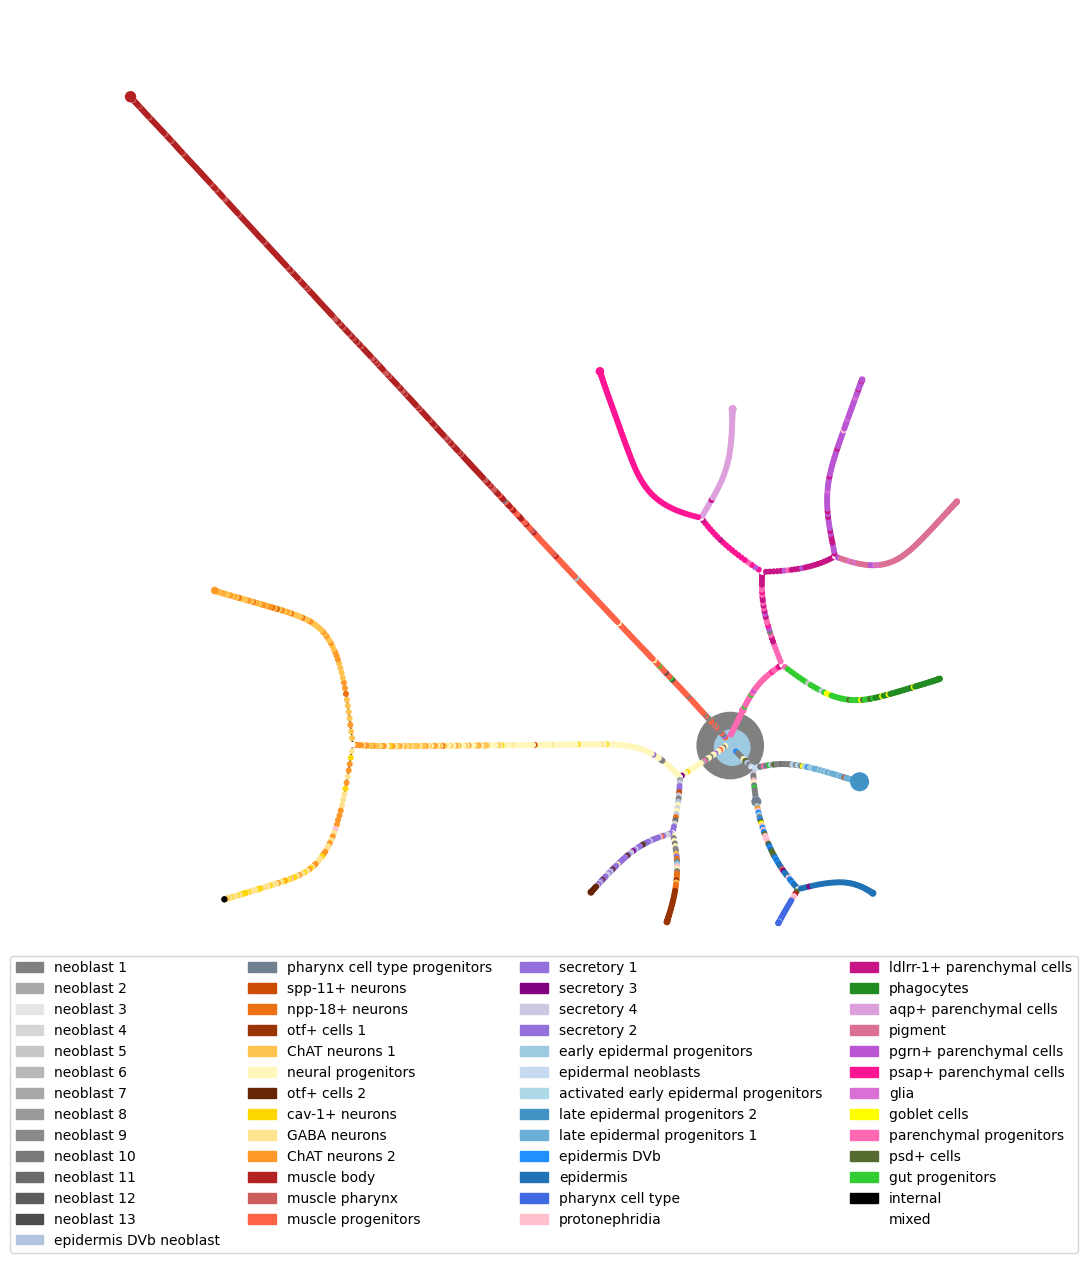

In [38]:
fig = tree.plot(labels = labels, 
                colours = colors,
                add_legend = True, 
                move_legend = (.5,-.25),
                prog = 'twopi')

## References

* Plass, M., Solana, J., Wolf, F.A., Ayoub, S., Misios, A., Glažar, P., Obermayer, B., Theis, F.J., Kocks, C. and Rajewsky, N., 2018. Cell type atlas and lineage tree of a whole complex animal by single-cell transcriptomics. Science, 360(6391), p.eaaq1723.

* Whiteley, N., Gray, A. and Rubin-Delanchy, P., 2022. Statistical exploration of the Manifold Hypothesis.

* Gray, A., Modell, A., Rubin-Delanchy, P. and Whiteley, N., 2024. Hierarchical clustering with dot products recovers hidden tree structure. Advances in Neural Information Processing Systems, 36.